In [1]:
import sys, os
import sparse
import xsimlab as xs
import xarray as xr
import numpy as np
import pandas as pd
import igraph as ig
from pgljupyter import SceneWidget

In [2]:
sys.path.insert(0, os.path.join(os.getcwd(), '..'))
import vmlab
from vmlab.models import arch_dev_model
from vmlab.enums import Nature

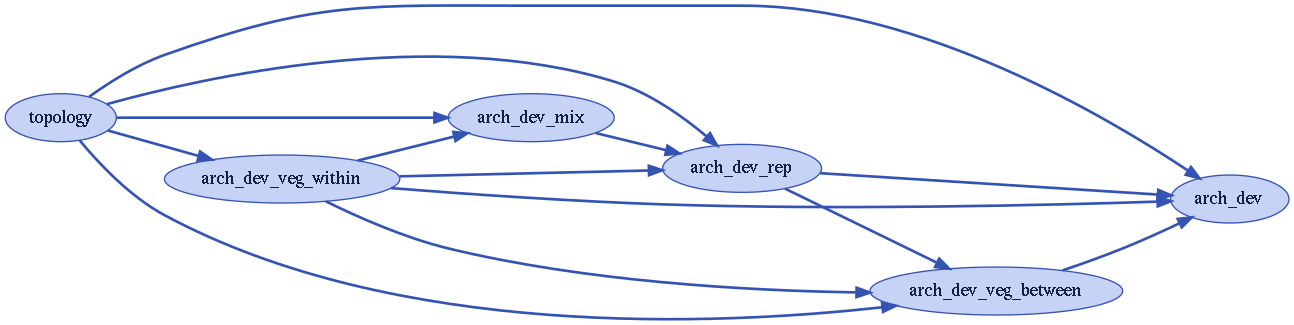

In [3]:
arch_dev_model.visualize()

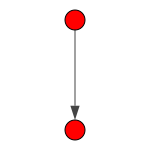

In [4]:
tree = pd.DataFrame({
    'id': [0, 1],
    'parent_id': [np.nan, 0],
    'cycle': [3, 3],
    'is_apical': [1, 1],
    'appearance_month': [2, 2],
    'ancestor_nature': [0, 0],
    'ancestor_is_apical': [1, 1],
    'nature': [0, 0]
})
in_g = ig.Graph.DataFrame(tree.dropna())
ig.plot(in_g, bbox=(0,0,150,150), layout=in_g.layout_reingold_tilford())

In [5]:
start_date='2003-06-01'
end_date='2006-06-01'
ds = vmlab.create_setup(
    model=arch_dev_model,
    tree=tree,
    start_date=start_date,
    end_date=end_date,
    setup_toml='../share/setup/vmango.toml',
    current_cycle=3,
    input_vars={
        'topology__seed': 11
    },
    output_vars=None
)

In [6]:
ds_out = ds.xsimlab.run(model=arch_dev_model, decoding={ 'mask_and_scale': False }, hooks=[xs.monitoring.ProgressBar()])
ds_out

             0% | initialize 

<xarray.Dataset>
Dimensions:                                             (GU: 19, day: 1097)
Coordinates:
  * GU                                                  (GU) <U10 'GU0' ... '...
  * day                                                 (day) datetime64[ns] ...
Data variables:
    arch_dev__pot_burst_date                            (GU) datetime64[D] Na...
    arch_dev__pot_flowering_date                        (GU) datetime64[D] Na...
    arch_dev__pot_has_apical_child                      (GU) float32 0.0 ... 0.0
    arch_dev__pot_nature                                (GU) float32 0.0 ... 0.0
    arch_dev__pot_nb_fruit                              (GU) float32 0.0 ... 0.0
    arch_dev__pot_nb_inflo                              (GU) float32 0.0 ... 0.0
    arch_dev__pot_nb_lateral_children                   (GU) float32 0.0 ... 0.0
    arch_dev_mix__has_mixed_inflo_children_between      (GU) float32 0.0 ... 0.0
    arch_dev_mix__parameter_file_path                   <U46 '../share/setup/...
    arch_dev_rep__flowering                             (GU) float32 0.0 ... 0.0
    arch_dev_rep__flowering_date                        (GU) datetime64[D] Na...
    arch_dev_rep__flowering_week                        (GU) float32 0.0 ... 0.0
    arch_dev_rep__fruiting                              (GU) float32 0.0 ... 0.0
    arch_dev_rep__nature                                (GU) float32 0.0 ... 0.0
    arch_dev_rep__nb_fruits                             (GU) float32 0.0 ... 0.0
    arch_dev_rep__nb_inflorescences                     (GU) float32 0.0 ... 0.0
    arch_dev_rep__parameter_file_path                   <U46 '../share/setup/...
    arch_dev_veg_between__burst_date_children_between   (GU) datetime64[D] Na...
    arch_dev_veg_between__burst_month_children_between  (GU) int8 5 5 0 ... 0 0
    arch_dev_veg_between__has_apical_child_between      (GU) float32 0.0 ... 0.0
    arch_dev_veg_between__has_lateral_children_between  (GU) float32 0.0 ... 0.0
    arch_dev_veg_between__has_veg_children_between      (GU) float32 0.0 ... 0.0
    arch_dev_veg_between__nb_lateral_children_between   (GU) float32 0.0 ... 0.0
    arch_dev_veg_between__parameter_file_path           <U54 '../share/setup/...
    arch_dev_veg_within__burst_date_children_within     (GU) datetime64[D] Na...
    arch_dev_veg_within__burst_month_children_within    (GU) int8 5 5 2 ... 0 0
    arch_dev_veg_within__has_apical_child_within        (GU) float32 0.0 ... 0.0
    arch_dev_veg_within__has_lateral_children_within    (GU) float32 0.0 ... 0.0
    arch_dev_veg_within__has_veg_children_within        (GU) float32 0.0 ... 0.0
    arch_dev_veg_within__nb_lateral_children_within     (GU) float32 0.0 ... 0.0
    arch_dev_veg_within__parameter_file_path            <U53 '../share/setup/...
    topology__adjacency                                 (GU, GU) float32 0.0 ...
    topology__ancestor                                  (GU) float32 0.0 ... 6.0
    topology__ancestor_is_apical                        (GU) float32 1.0 ... 0.0
    topology__ancestor_nature                           (GU) float32 0.0 ... 2.0
    topology__appearance_date                           (GU) datetime64[D] Na...
    topology__appearance_month                          (GU) float32 2.0 ... 3.0
    topology__appeared                                  (GU) float32 0.0 ... 0.0
    topology__bursted                                   (GU) float32 0.0 ... 0.0
    topology__current_cycle                             int64 6
    topology__cycle                                     (GU) float32 3.0 ... 5.0
    topology__distance                                  (GU, GU) float64 0.0 ...
    topology__doy_begin_flowering                       int64 214
    topology__is_apical                                 (GU) float32 1.0 ... 0.0
    topology__is_initially_terminal                     (GU) bool False ... F...
    topology__month_begin_veg_cycle                     int64 7
    topology__nb_descendants             

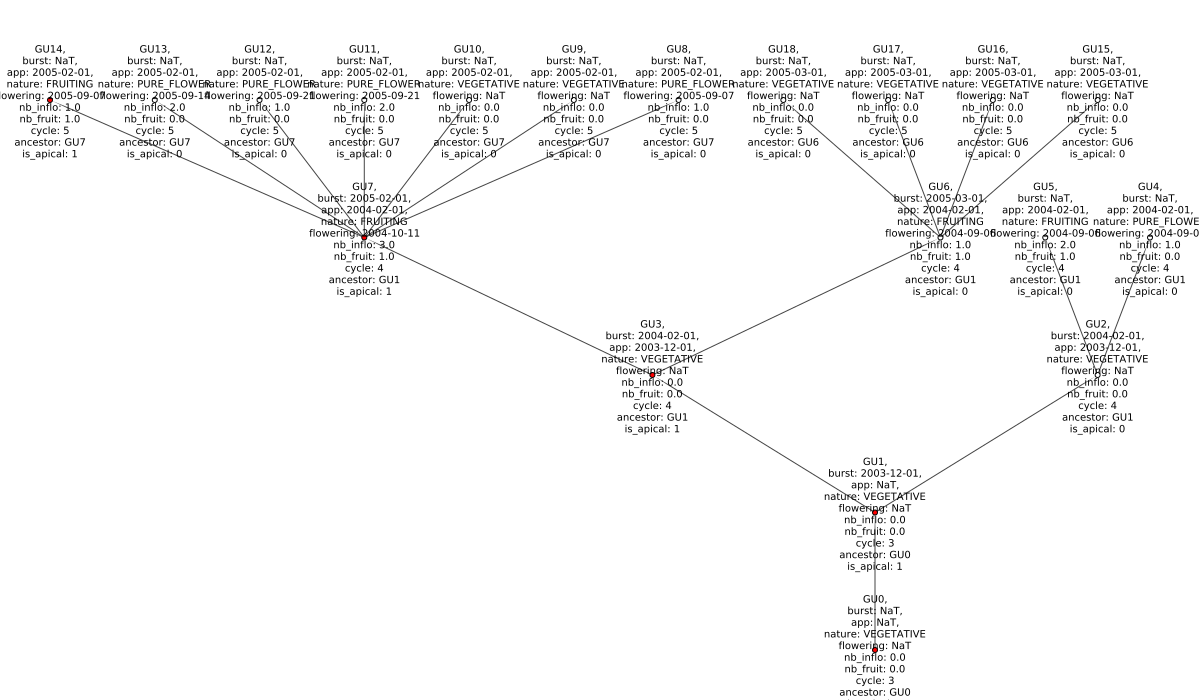

In [8]:
Nature_Names = {v: k for k, v in Nature.items()}
out_g = ig.Graph.Adjacency([row.tolist() for row in ds_out.topology__adjacency.data.astype(np.int64)])
out_layout = out_g.layout_reingold_tilford(root=0.)
out_layout.rotate(-180)
ig.plot(out_g, layout=out_layout, bbox=(1200, 700), margin=(50, 100, 50, 50), **{
    'vertex_size': 5,
    'vertex_label_size': 10,
    'edge_arrow_width': 0.1,
    'vertex_color': ['red' if is_apical else 'white' for is_apical in ds_out.topology__is_apical.data],
    'vertex_label': [
        f'GU{idx}, \
        \nburst: {ds_out.arch_dev__pot_burst_date.data[idx]}, \
        \napp: {ds_out.topology__appearance_date.data[idx]}, \
        \nnature: {Nature_Names[ds_out.arch_dev__pot_nature.data[idx]]} \
        \nflowering: {ds_out.arch_dev__pot_flowering_date.data[idx]} \
        \nnb_inflo: {ds_out.arch_dev__pot_nb_inflo.data[idx]} \
        \nnb_fruit: {ds_out.arch_dev__pot_nb_fruit.data[idx]} \
        \ncycle: {int(ds_out.topology__cycle.data[idx])} \
        \nancestor: GU{int(ds_out.topology__ancestor.data[idx])} \
        \nis_apical: {int(ds_out.topology__is_apical.data[idx])}' \
        for idx in out_g.vs.indices
    ]
})